## Untersuchung PINN für das Lorenz System bei nicht chaotischen Parametern 

Grundlage der Untersuchung ist das Lorenz System: 

\begin{align}
\dot x &= \sigma (y - x) \\
\dot y &= r x - y - xz \\
\dot z &= xy - b z
\end{align}

Die beiden Parameter $\sigma$ und $b$ sind als Konstanten mit den Werten $\sigma = 10$ und $b = \frac{8}{3}$ zu betrachten.
Der einzige zu variierende Parameter ist demnach $r$. 
Für $ r < 1$ ist der Ursprung $(x, y, z) = (0, 0, 0)$ der einzige globale Fixpunkt des Systems. Alle Bahnkurven enden daher unabhängig von der Anfangsbedingung im Ursprung.
Dieses Verhalten des Lorenz Systems sollte genauso durch ein PINN gelernt werden können.

Der nachfolgende Programmcode dient dazu, dies zu untersuchen.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pinn
import neural_networks as nns
import helper_functions as hf
import pinn_helper_functions as phf

In [3]:
import inverse

In [4]:
def x_y_z_plotter(t_eval, solution_rk45, pinn_solution, title):
    plt.figure(figsize=(12, 8))
    labels = ['x', 'y', 'z']

    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(t_eval, solution_rk45.y[i], 'k-', label="RK45 Reference Solution")
        plt.plot(t_eval, pinn_solution[:, i], 'b-.', label="PINN Solution")
        plt.ylabel(labels[i])
        if i == 0:
            plt.title(title)
        if i == 2:
            plt.xlabel("t")
        plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [5]:
def pinn_reference_mse(reference_solution, pinn_solution):
    return tf.reduce_mean((reference_solution.y.transpose() - pinn_solution)**2)

def pinn_ic_mse(reference_solution, pinn_solution):
    reference_ic = reference_solution.y.transpose()[0]
    pinn_ic = pinn_solution[0]
    return tf.reduce_mean((reference_ic - pinn_ic)**2)

In [6]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 10
C = 8/3


# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 5000 #25000
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

### Anfangsbedingungen: (1, 1, 1)

In [7]:
# Create RK-45 reference solution
base_IC = np.array([1.0, 1.0, 1.0], dtype=np.float32)
B_0 = 0.0
t_eval, sol_rk45_base_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, base_IC)
B_1 = 0.5
t_eval, sol_rk45_base_IC_r1 = hf.ref_solution(A, B_1, C, t_min, t_max, base_IC)
B_2 = 0.99
t_eval, sol_rk45_base_IC_r2 = hf.ref_solution(A, B_2, C, t_min, t_max, base_IC)

#### Einschub: Inverses Problem für r=0, bei IC = (1, 1, 1)

In [ ]:
# Trainable parameters
A = tf.Variable(10.0, dtype=tf.float32, trainable=False, name="A")
B = tf.Variable(2, dtype=tf.float32, trainable=True, name="B")
C = tf.Variable(8/3, dtype=tf.float32, trainable=False, name="C")

# System parameters (cusotmizable by programmer)
True_A, True_B, True_C = 10, 0, 8/3

# Create reference and noisy data
t_eval, sol = hf.ref_solution(True_A, True_B, True_C, t_min, t_max=3, initial_conditions=base_IC)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max=3, noise_factor=0.005)

# Build model
model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

# Train model
inverse.train(
    model,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B, C=C,
    t_min=t_min, t_max=3,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=0.01,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    t_data=t_data,
    y_data=y_data,
    trainable_parameters = [B]
)

In [ ]:
t_plot = tf.convert_to_tensor(t_eval.reshape(-1, 1), dtype=tf.float32)
y_pred_pinn = model(t_plot).numpy()

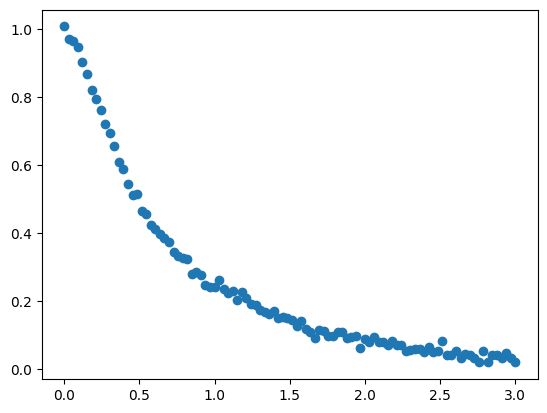

In [165]:
x = y_data[:, 0]
plt.scatter(t_data, x)

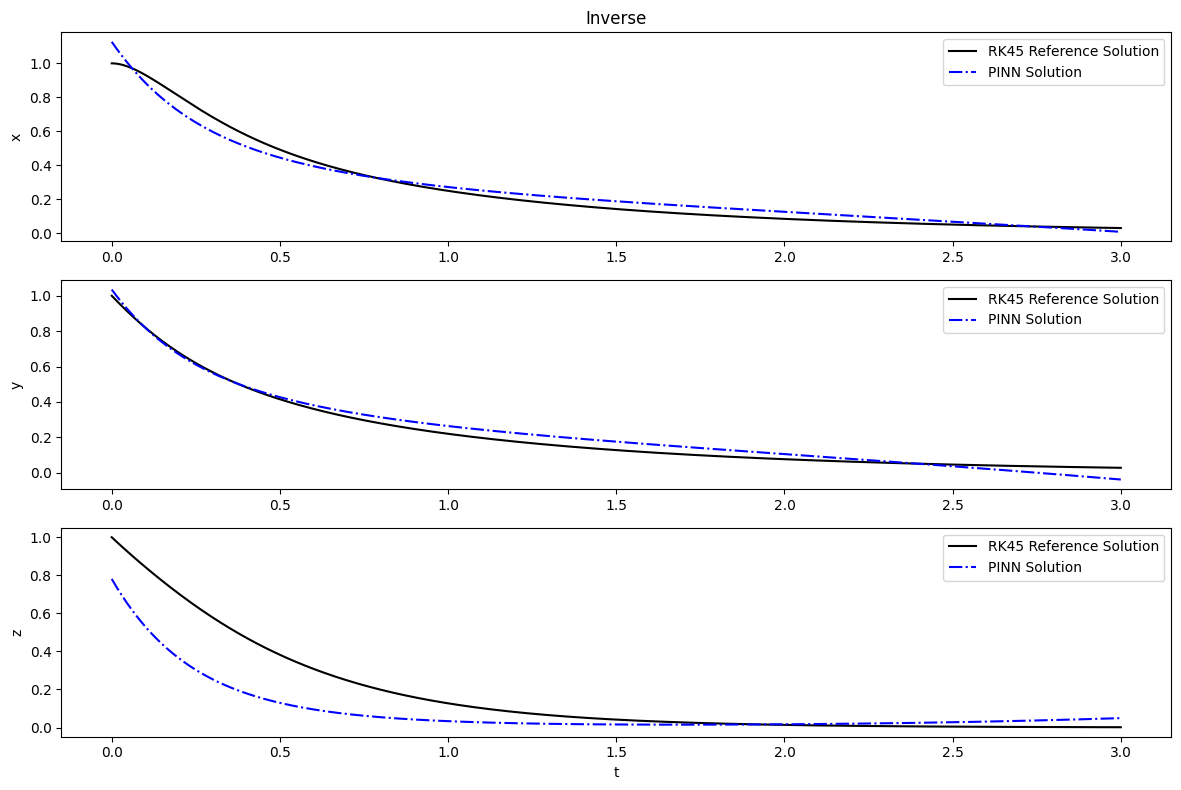

In [166]:
x_y_z_plotter(t_eval=t_eval, solution_rk45=sol, pinn_solution=y_pred_pinn, title="Inverse")

In [73]:
# Create PINN model without normalization
model_base_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_base_IC_r1 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_base_IC_r2 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [74]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 1.1043487787246704 | IC-Loss: 1.0 | Physics-Loss: 1.2086975574493408
Epoch 1000 Loss: 0.00042901639244519174 | IC-Loss: 7.998217915883288e-05 | Physics-Loss: 0.0007780506275594234
Epoch 2000 Loss: 0.0004108629946131259 | IC-Loss: 6.18464473518543e-05 | Physics-Loss: 0.0007598795345984399
Epoch 3000 Loss: 0.00035387586103752255 | IC-Loss: 5.2547475206665695e-05 | Physics-Loss: 0.0006552042323164642
Epoch 4000 Loss: 0.00034143077209591866 | IC-Loss: 5.109068297315389e-05 | Physics-Loss: 0.0006317708757705986
Training finished!


In [75]:
y_pinn_base_IC_r0, phys_loss_r0 = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)


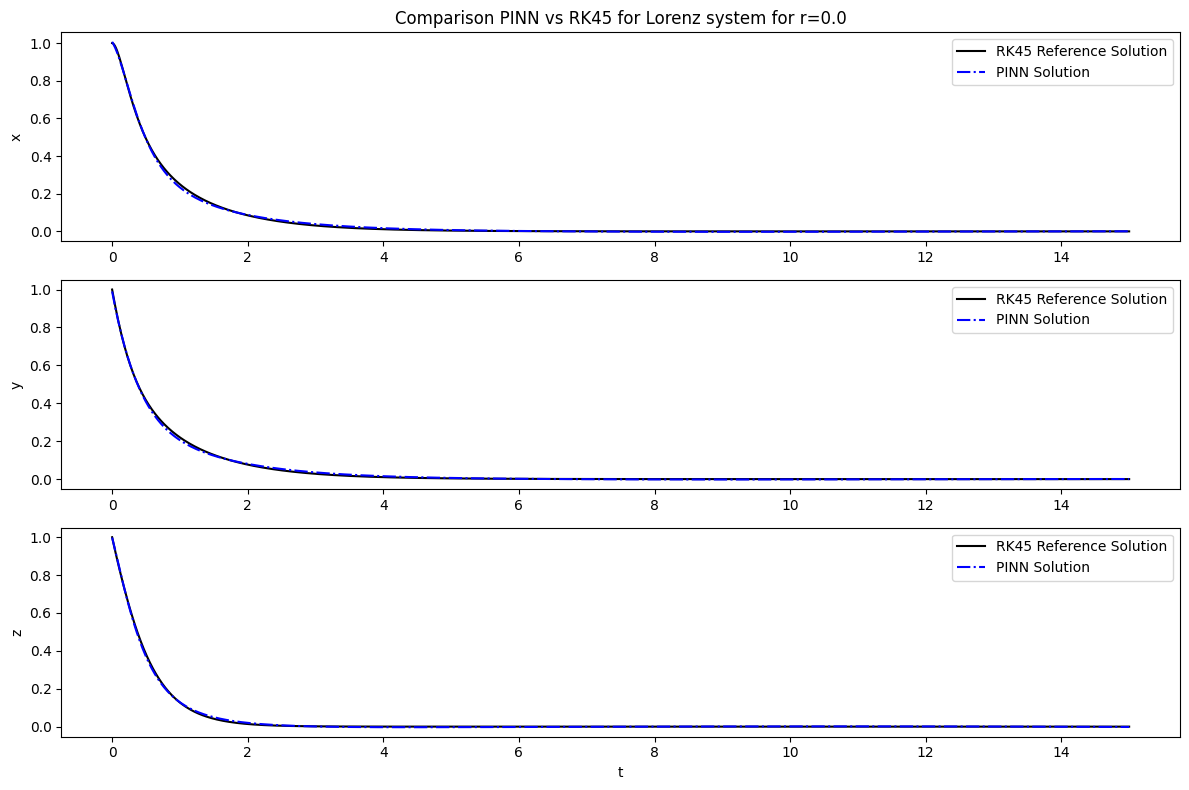

In [76]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

In [77]:
pinn.train(
    model_base_IC_r1,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_1, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=False,
    t_data=None,
    y_data=None
    )

Training started...
Epoch 0 Loss: 9.62105655670166 | IC-Loss: 1.0 | Physics-Loss: 18.24211311340332
Epoch 1000 Loss: 0.001218609744682908 | IC-Loss: 0.0015148151433095336 | Physics-Loss: 0.0009224044042639434
Epoch 2000 Loss: 0.0014730521943420172 | IC-Loss: 0.001479746657423675 | Physics-Loss: 0.0014663578476756811
Epoch 3000 Loss: 0.0012853830121457577 | IC-Loss: 0.0014663500478491187 | Physics-Loss: 0.0011044159764423966
Epoch 4000 Loss: 0.0014789884444326162 | IC-Loss: 0.0014674649573862553 | Physics-Loss: 0.0014905119314789772
Training finished!


In [78]:
y_pinn_base_IC_r1, phys_loss_r1 = pinn.pinn_predict(model_base_IC_r1, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_1, C=C)
ic_mse_r1 = pinn_ic_mse(sol_rk45_base_IC_r1, y_pinn_base_IC_r1)
reference_mse_r1 = pinn_reference_mse(sol_rk45_base_IC_r1, y_pinn_base_IC_r1)

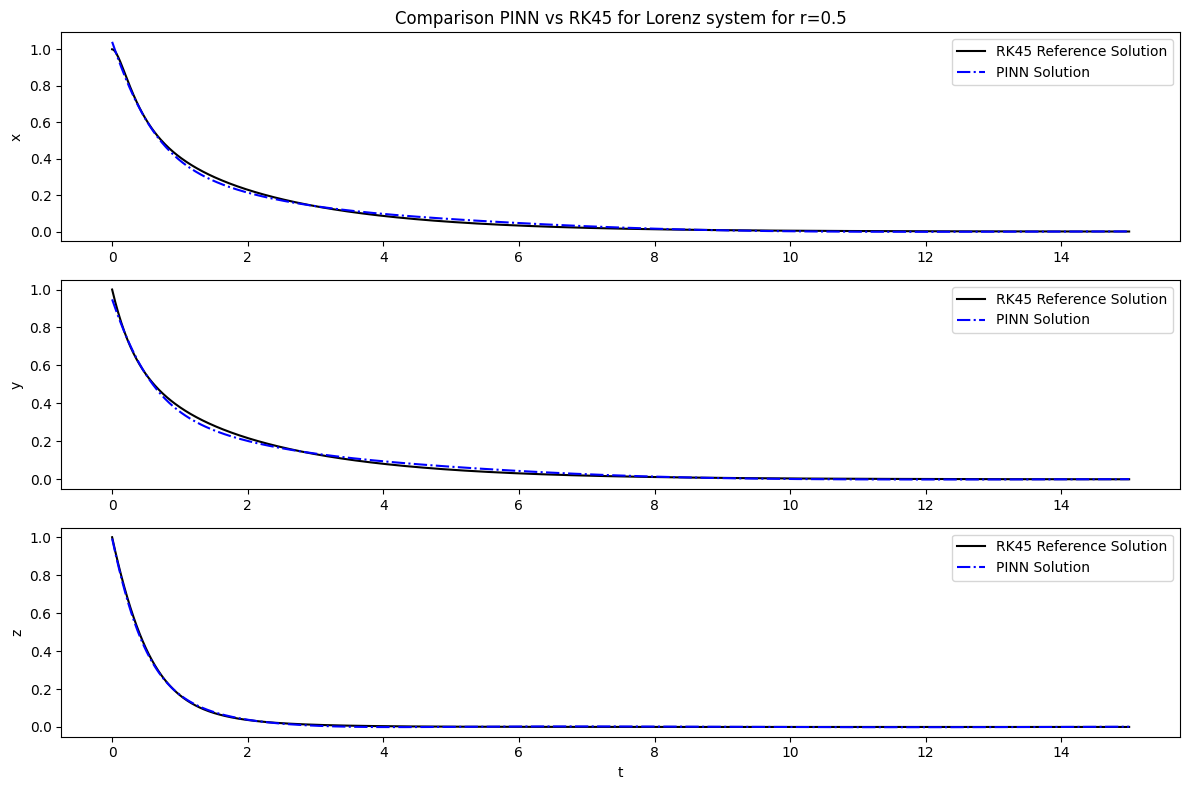

In [79]:
title_r1 = f"Comparison PINN vs RK45 for Lorenz system for r={B_1}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r1,
    pinn_solution=y_pinn_base_IC_r1,
    title=title_r1
)

In [80]:
pinn.train(
    model_base_IC_r2,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_2, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=False,
    t_data=None,
    y_data=None
    )

Training started...
Epoch 0 Loss: 1.589756727218628 | IC-Loss: 1.0 | Physics-Loss: 2.179513454437256
Epoch 1000 Loss: 0.0004291041404940188 | IC-Loss: 0.0004217779205646366 | Physics-Loss: 0.00043643033131957054
Epoch 2000 Loss: 0.0004048440605401993 | IC-Loss: 0.00036264045047573745 | Physics-Loss: 0.00044704769970849156
Epoch 3000 Loss: 0.0004540737718343735 | IC-Loss: 0.0003583871584851295 | Physics-Loss: 0.0005497604142874479
Epoch 4000 Loss: 0.00029290004749782383 | IC-Loss: 0.0003566420928109437 | Physics-Loss: 0.00022915800218470395
Training finished!


In [81]:
y_pinn_base_IC_r2, phys_loss_r2 = pinn.pinn_predict(model_base_IC_r2, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_2, C=C)
ic_mse_r2 = pinn_ic_mse(sol_rk45_base_IC_r2, y_pinn_base_IC_r2)
reference_mse_r2 = pinn_reference_mse(sol_rk45_base_IC_r2, y_pinn_base_IC_r2)

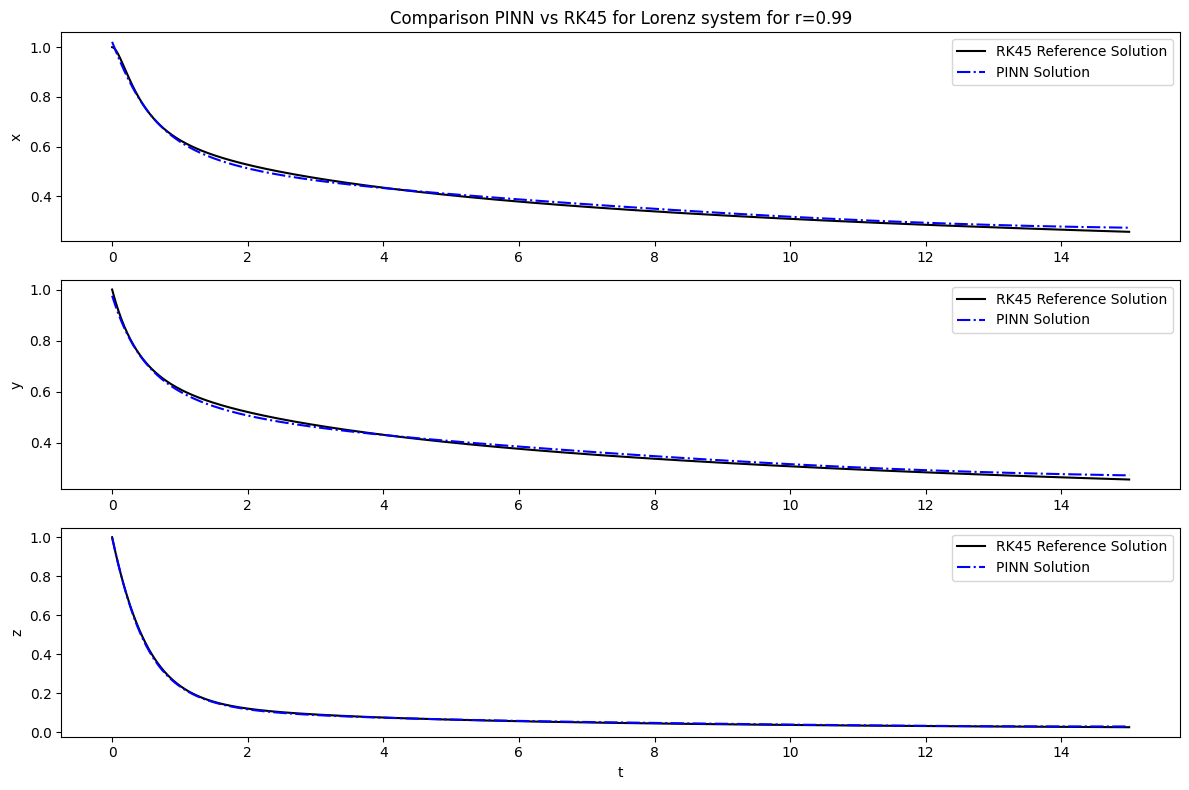

In [82]:
title_r2 = f"Comparison PINN vs RK45 for Lorenz system for r={B_2}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r2,
    pinn_solution=y_pinn_base_IC_r2,
    title=title_r2
)

#### Anfangsbedigung (10, -5, 20)
Diese Anfangsbedingung liegt relativ weit von möglichen Fixpunkten des Systems entfernt und soll Anfangsbedingungen mit relativ hohen Werten repräsentieren.

In [83]:
high_IC = np.array([10.0, -5.0, 20.0], dtype=np.float32)
t_eval, sol_rk45_high_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, high_IC)
t_eval, sol_rk45_high_IC_r1 = hf.ref_solution(A, B_1, C, t_min, t_max, high_IC)
t_eval, sol_rk45_high_IC_r2 = hf.ref_solution(A, B_2, C, t_min, t_max, high_IC)

model_high_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_high_IC_r1 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_high_IC_r2 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [84]:
pinn.train(
    model_high_IC_r0,
    t_initial=t_min,
    initial_conditions=high_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
)


Training started...
Epoch 0 Loss: 87.50000762939453 | IC-Loss: 175.0 | Physics-Loss: 1.606547084520571e-05
Epoch 1000 Loss: 0.16291150450706482 | IC-Loss: 0.06555019319057465 | Physics-Loss: 0.2602728307247162
Epoch 2000 Loss: 0.12564967572689056 | IC-Loss: 0.0029336533043533564 | Physics-Loss: 0.24836570024490356
Epoch 3000 Loss: 0.023674922063946724 | IC-Loss: 0.002782045863568783 | Physics-Loss: 0.04456779733300209
Epoch 4000 Loss: 0.03660894185304642 | IC-Loss: 0.0024368471931666136 | Physics-Loss: 0.07078103721141815
Training finished!


In [86]:
y_pinn_high_IC_r0, phys_loss_high_IC_r0 = pinn.pinn_predict(model_high_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_high_IC_r0 = pinn_ic_mse(sol_rk45_high_IC_r0, y_pinn_high_IC_r0)
reference_mse_high_IC_r0 = pinn_reference_mse(sol_rk45_high_IC_r0, y_pinn_high_IC_r0)

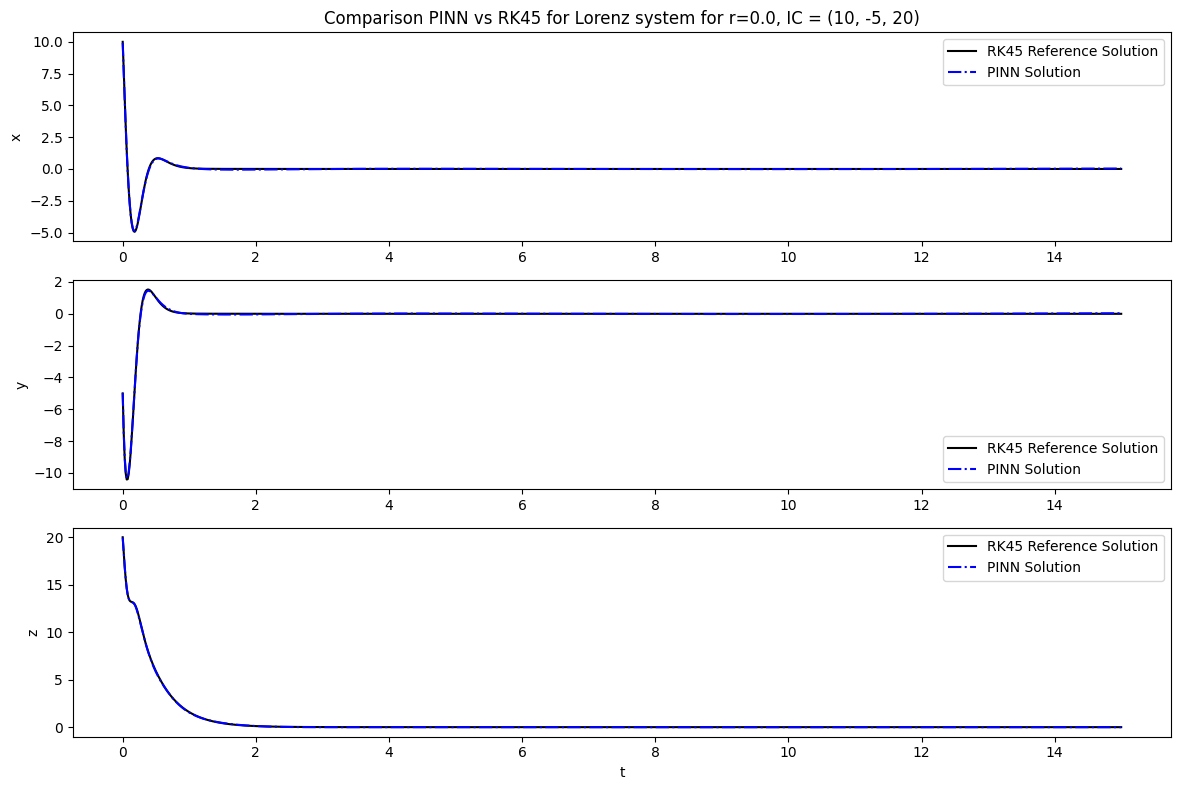

In [87]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (10, -5, 20)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_high_IC_r0,
    pinn_solution=y_pinn_high_IC_r0,
    title=title
)

In [88]:
pinn.train(
    model_high_IC_r1,
    t_initial=t_min,
    initial_conditions=high_IC,
    A=A, B=B_1, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
)


Training started...
Epoch 0 Loss: 87.50013732910156 | IC-Loss: 175.0 | Physics-Loss: 0.00026813571457751095
Epoch 1000 Loss: 0.3284956216812134 | IC-Loss: 0.3106164038181305 | Physics-Loss: 0.3463748097419739
Epoch 2000 Loss: 0.11960827559232712 | IC-Loss: 0.01676747389137745 | Physics-Loss: 0.22244907915592194
Epoch 3000 Loss: 0.09746401011943817 | IC-Loss: 0.02050977572798729 | Physics-Loss: 0.17441824078559875
Epoch 4000 Loss: 0.07219560444355011 | IC-Loss: 0.02121133543550968 | Physics-Loss: 0.12317986786365509
Training finished!


In [89]:
y_pinn_high_IC_r1, phys_loss_high_IC_r1 = pinn.pinn_predict(model_high_IC_r1, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_1, C=C)
ic_mse_high_IC_r1 = pinn_ic_mse(sol_rk45_high_IC_r1, y_pinn_high_IC_r1)
reference_mse_high_IC_r1 = pinn_reference_mse(sol_rk45_high_IC_r1, y_pinn_high_IC_r1)

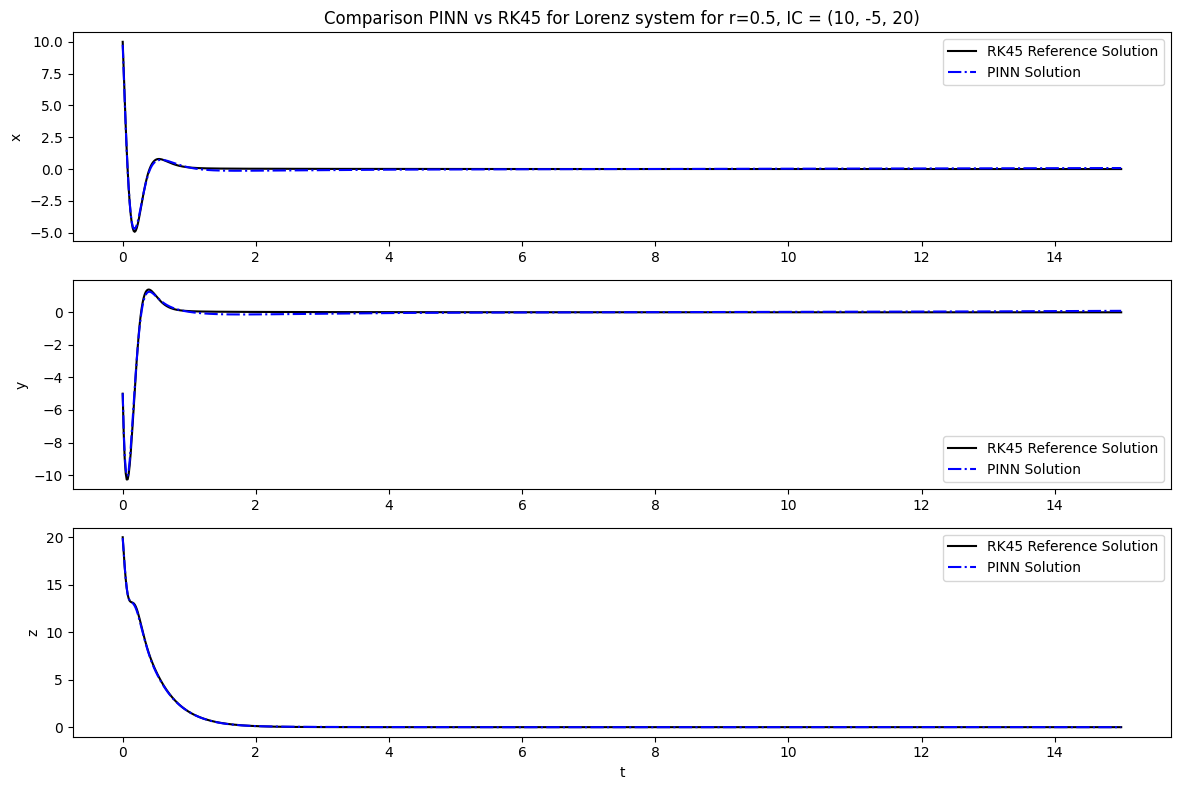

In [90]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_1}, IC = (10, -5, 20)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_high_IC_r1,
    pinn_solution=y_pinn_high_IC_r1,
    title=title
)

In [91]:
pinn.train(
    model_high_IC_r2,
    t_initial=t_min,
    initial_conditions=high_IC,
    A=A, B=B_2, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
)


Training started...
Epoch 0 Loss: 87.50067138671875 | IC-Loss: 175.0 | Physics-Loss: 0.0013406809885054827
Epoch 1000 Loss: 0.6655067205429077 | IC-Loss: 0.18285542726516724 | Physics-Loss: 1.148158073425293
Epoch 2000 Loss: 0.7841876745223999 | IC-Loss: 0.09023318439722061 | Physics-Loss: 1.4781421422958374
Epoch 3000 Loss: 0.20407246053218842 | IC-Loss: 0.09101167321205139 | Physics-Loss: 0.31713324785232544
Epoch 4000 Loss: 0.2101292610168457 | IC-Loss: 0.07626421004533768 | Physics-Loss: 0.3439943194389343
Training finished!


In [92]:
y_pinn_high_IC_r2, phys_loss_high_IC_r2 = pinn.pinn_predict(model_high_IC_r2, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_2, C=C)
ic_mse_high_IC_r2 = pinn_ic_mse(sol_rk45_high_IC_r2, y_pinn_high_IC_r2)
reference_mse_high_IC_r2 = pinn_reference_mse(sol_rk45_high_IC_r2, y_pinn_high_IC_r2)

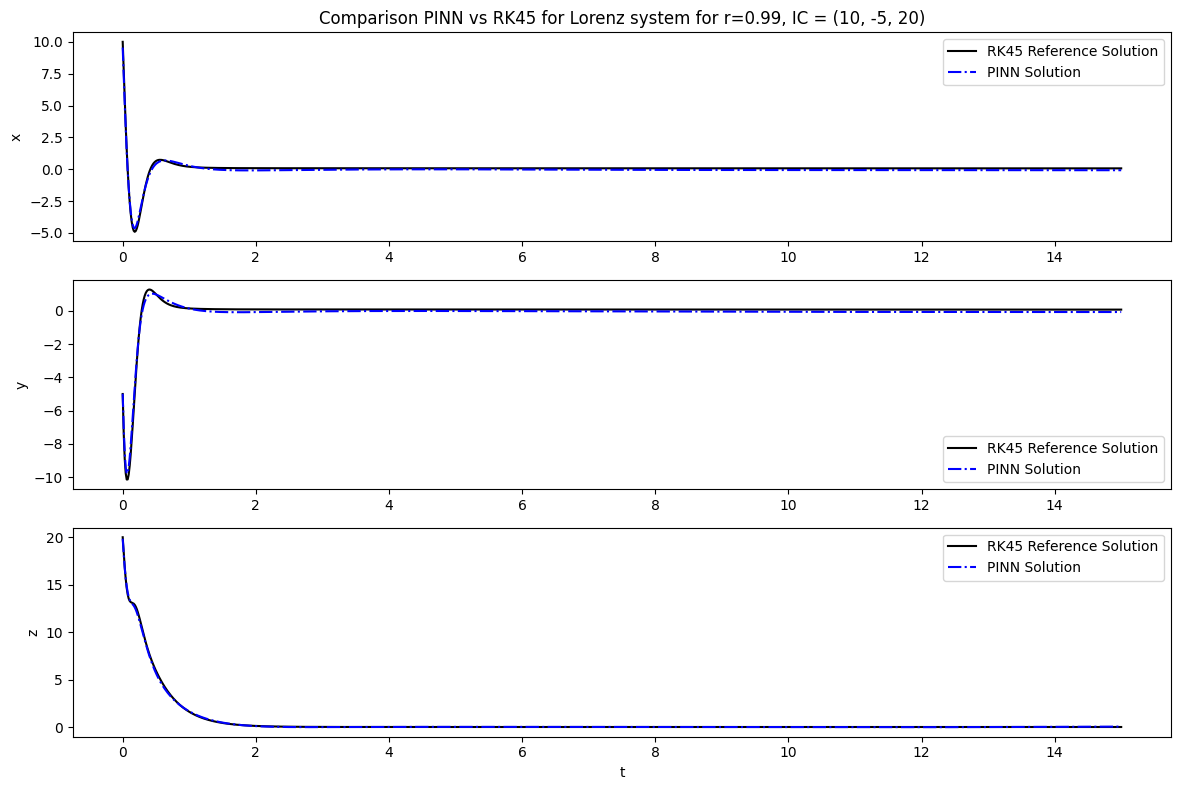

In [93]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_2}, IC = (10, -5, 20)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_high_IC_r2,
    pinn_solution=y_pinn_high_IC_r2,
    title=title
)

#### Anfangsbedingung (0, 1, 0)
Von Lorenz gewählte Anfangsbedingung.

In [94]:
lorenz_IC = np.array([0.0, 1.0, 0.0], dtype=np.float32)
t_eval, sol_rk45_lorenz_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, lorenz_IC)
t_eval, sol_rk45_lorenz_IC_r1 = hf.ref_solution(A, B_1, C, t_min, t_max, lorenz_IC)
t_eval, sol_rk45_lorenz_IC_r2 = hf.ref_solution(A, B_2, C, t_min, t_max, lorenz_IC)

model_lorenz_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_lorenz_IC_r1 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_lorenz_IC_r2 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [95]:
pinn.train(
    model_lorenz_IC_r0,
    t_initial=t_min,
    initial_conditions=lorenz_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.16671057045459747 | IC-Loss: 0.3333333432674408 | Physics-Loss: 8.780173084232956e-05
Epoch 1000 Loss: 0.0004491482104640454 | IC-Loss: 1.5484729374293238e-06 | Physics-Loss: 0.0008967479225248098
Epoch 2000 Loss: 9.579391189618036e-05 | IC-Loss: 6.267966909945244e-07 | Physics-Loss: 0.00019096102914772928
Epoch 3000 Loss: 6.835402746219188e-05 | IC-Loss: 1.561660269544518e-06 | Physics-Loss: 0.00013514640158973634
Epoch 4000 Loss: 0.00017726217629387975 | IC-Loss: 1.5595610420859884e-06 | Physics-Loss: 0.00035296479472890496
Training finished!


In [103]:
y_pinn_lorenz_IC_r0, phys_loss_lorenz_IC_r0 = pinn.pinn_predict(model_lorenz_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_lorenz_IC_r0 = pinn_ic_mse(sol_rk45_lorenz_IC_r0, y_pinn_lorenz_IC_r0)
reference_mse_lorenz_IC_r0 = pinn_reference_mse(sol_rk45_lorenz_IC_r0, y_pinn_lorenz_IC_r0)


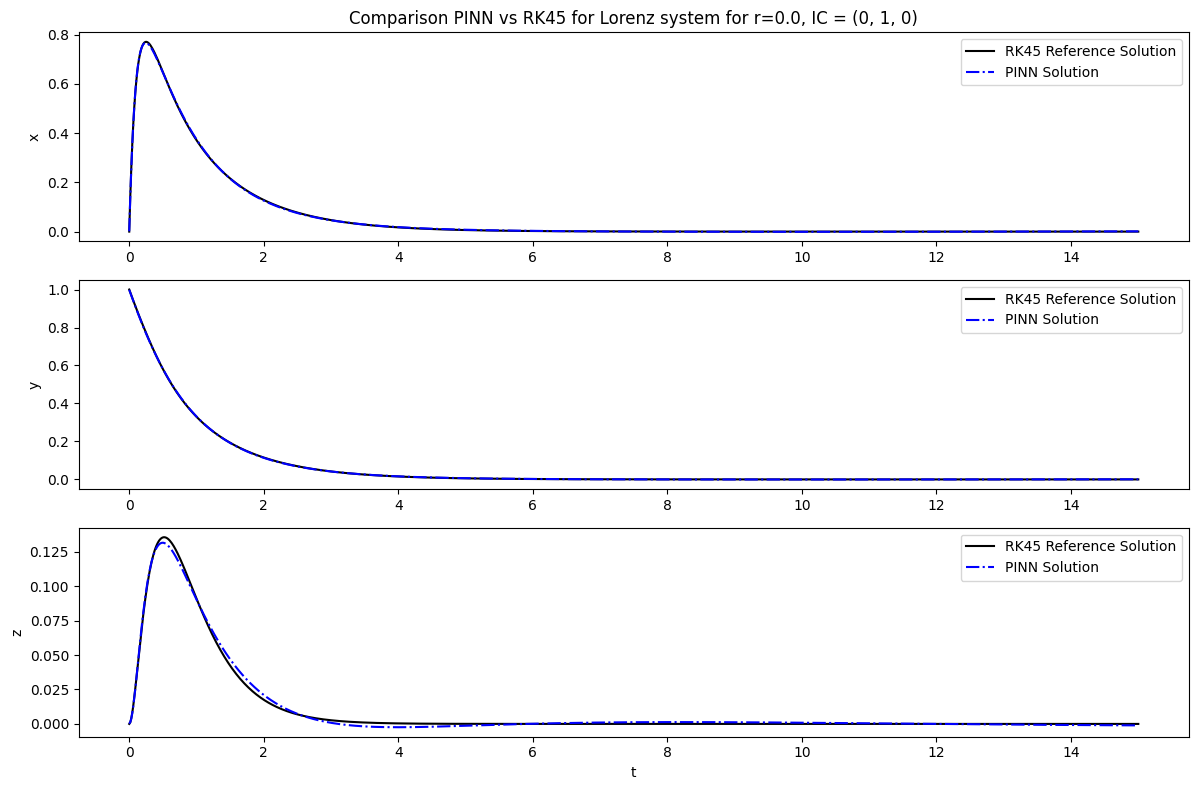

In [104]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0, 1, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_lorenz_IC_r0,
    pinn_solution=y_pinn_lorenz_IC_r0,
    title=title
)

In [105]:
pinn.train(
    model_lorenz_IC_r1,
    t_initial=t_min,
    initial_conditions=lorenz_IC,
    A=A, B=B_1, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.16761192679405212 | IC-Loss: 0.3333333432674408 | Physics-Loss: 0.0018905217293649912
Epoch 1000 Loss: 0.00014436605852097273 | IC-Loss: 6.1603700487466995e-06 | Physics-Loss: 0.0002825717383529991
Epoch 2000 Loss: 0.00012203142250655219 | IC-Loss: 1.536521608613839e-06 | Physics-Loss: 0.00024252632283605635
Epoch 3000 Loss: 9.357828093925491e-05 | IC-Loss: 2.21298296310124e-06 | Physics-Loss: 0.00018494357937015593
Epoch 4000 Loss: 8.328301191795617e-05 | IC-Loss: 1.4039079587746528e-06 | Physics-Loss: 0.00016516211326234043
Training finished!


In [106]:
y_pinn_lorenz_IC_r1, phys_loss_lorenz_IC_r1 = pinn.pinn_predict(model_lorenz_IC_r1, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_1, C=C)
ic_mse_lorenz_IC_r1 = pinn_ic_mse(sol_rk45_lorenz_IC_r1, y_pinn_lorenz_IC_r1)
reference_mse_lorenz_IC_r1 = pinn_reference_mse(sol_rk45_lorenz_IC_r1, y_pinn_lorenz_IC_r1)

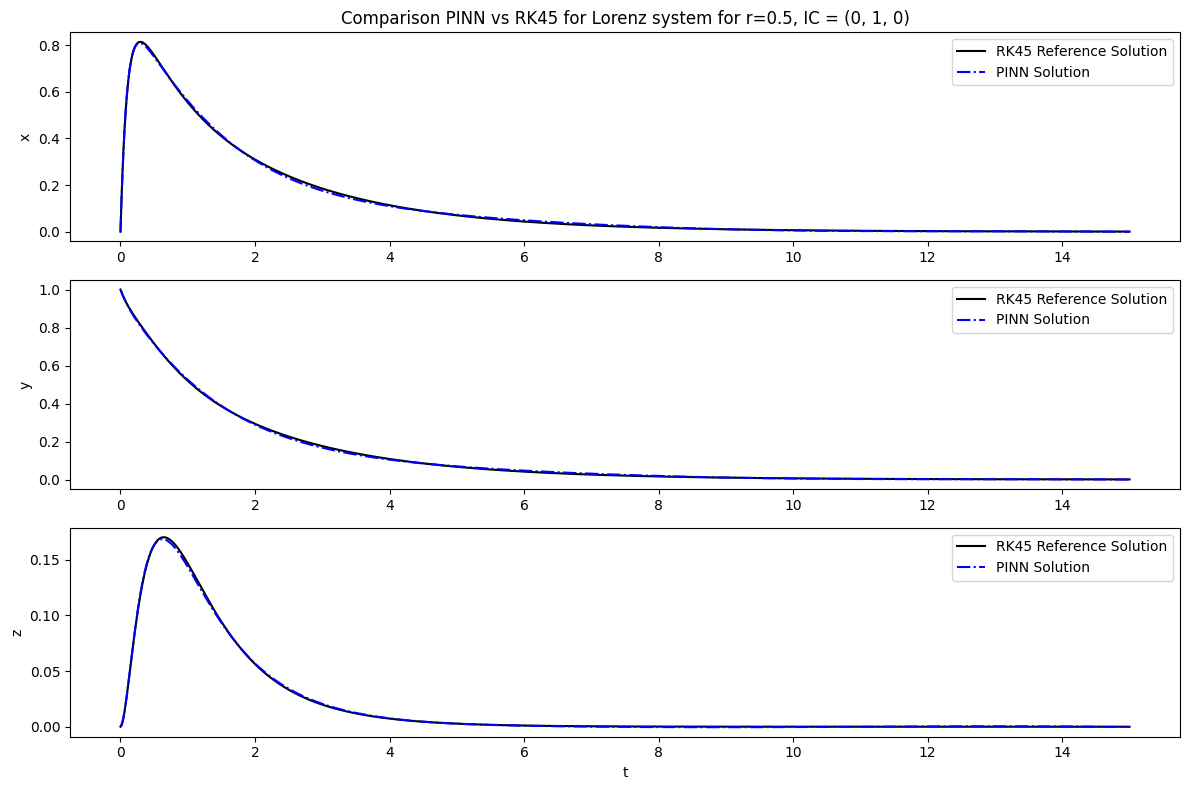

In [107]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_1}, IC = (0, 1, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_lorenz_IC_r1,
    pinn_solution=y_pinn_lorenz_IC_r1,
    title=title
)

In [ ]:
pinn.train(
    model_lorenz_IC_r2,
    t_initial=t_min,
    initial_conditions=lorenz_IC,
    A=A, B=B_2, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS + 1000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.06169145554304123 | IC-Loss: 0.08812272548675537 | Physics-Loss: 0.03526018559932709
Epoch 1000 Loss: 5.1162402087356895e-05 | IC-Loss: 9.744377393872128e-07 | Physics-Loss: 0.00010135036427527666
Epoch 2000 Loss: 4.792544132214971e-05 | IC-Loss: 5.266695666250598e-07 | Physics-Loss: 9.532421245239675e-05
Epoch 3000 Loss: 3.133351856376976e-05 | IC-Loss: 6.750979082426056e-07 | Physics-Loss: 6.19919374003075e-05
Epoch 4000 Loss: 4.3367752368794754e-05 | IC-Loss: 5.96676272834884e-07 | Physics-Loss: 8.613882528152317e-05
Training finished!


In [133]:
y_pinn_lorenz_IC_r2, phys_loss_lorenz_IC_r2 = pinn.pinn_predict(model_lorenz_IC_r2, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_2, C=C)
ic_mse_lorenz_IC_r2 = pinn_ic_mse(sol_rk45_lorenz_IC_r2, y_pinn_lorenz_IC_r2)
reference_mse_lorenz_IC_r2 = pinn_reference_mse(sol_rk45_lorenz_IC_r2, y_pinn_lorenz_IC_r2)

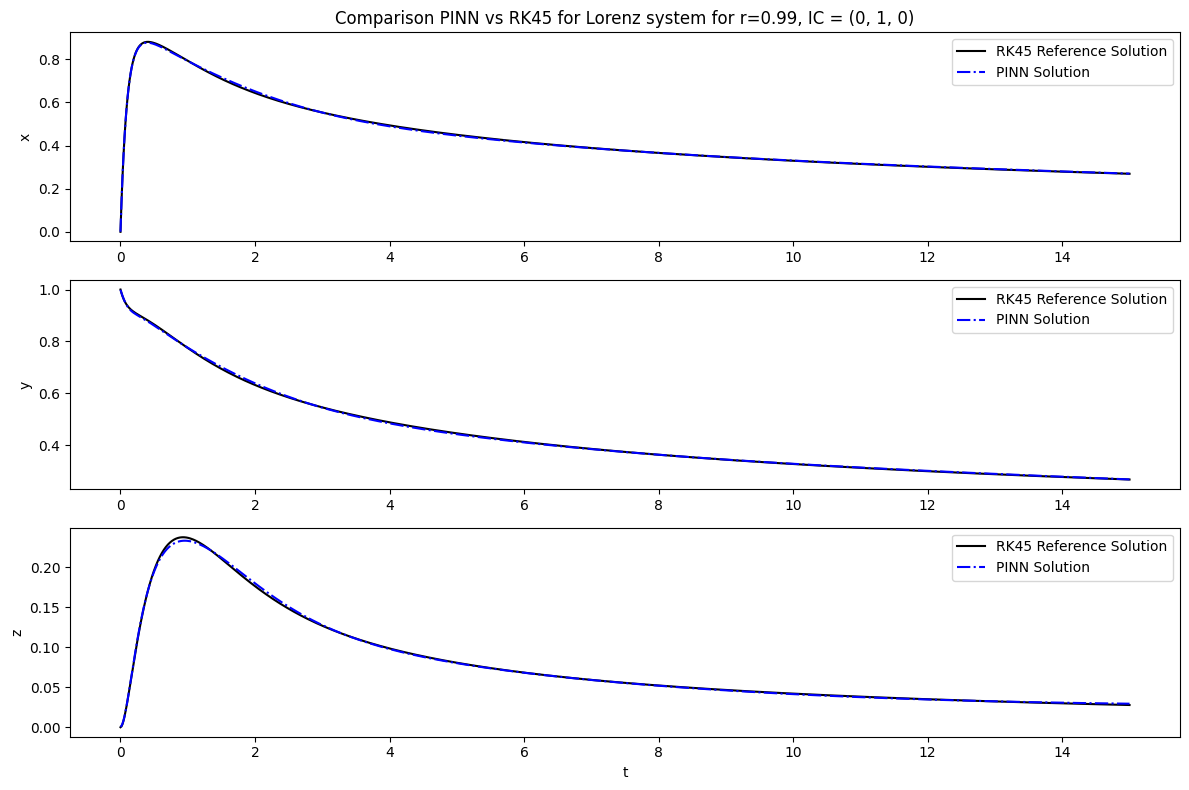

In [134]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_2}, IC = (0, 1, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_lorenz_IC_r2,
    pinn_solution=y_pinn_lorenz_IC_r2,
    title=title
)

#### Anfangsbedingung (0, 1.0001, 0)
Minimal abweichende Anfangsbedingung. 

In [111]:
sensitive_IC = np.array([0.0, 1.0001, 0.0], dtype=np.float32)
t_eval, sol_rk45_sensitive_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, sensitive_IC)
t_eval, sol_rk45_sensitive_IC_r1 = hf.ref_solution(A, B_1, C, t_min, t_max, sensitive_IC)
t_eval, sol_rk45_sensitive_IC_r2 = hf.ref_solution(A, B_2, C, t_min, t_max, sensitive_IC)

model_sensitive_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_sensitive_IC_r1 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_sensitive_IC_r2 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [112]:
pinn.train(
    model_sensitive_IC_r0,
    t_initial=t_min,
    initial_conditions=sensitive_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=4000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.16686439514160156 | IC-Loss: 0.33340001106262207 | Physics-Loss: 0.00032878946512937546
Epoch 1000 Loss: 0.0002568867930676788 | IC-Loss: 5.257968496152898e-06 | Physics-Loss: 0.0005085156299173832
Epoch 2000 Loss: 0.00010571629536570981 | IC-Loss: 2.791183987937984e-06 | Physics-Loss: 0.0002086414024233818
Epoch 3000 Loss: 0.00015008353511802852 | IC-Loss: 1.3289360367707559e-06 | Physics-Loss: 0.00029883813112974167
Training finished!


In [113]:
y_pinn_sensitive_IC_r0, phys_loss_sensitive_IC_r0 = pinn.pinn_predict(model_sensitive_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_sensitive_IC_r0 = pinn_ic_mse(sol_rk45_sensitive_IC_r0, y_pinn_sensitive_IC_r0)
reference_mse_sensitive_IC_r0 = pinn_reference_mse(sol_rk45_sensitive_IC_r0, y_pinn_sensitive_IC_r0)

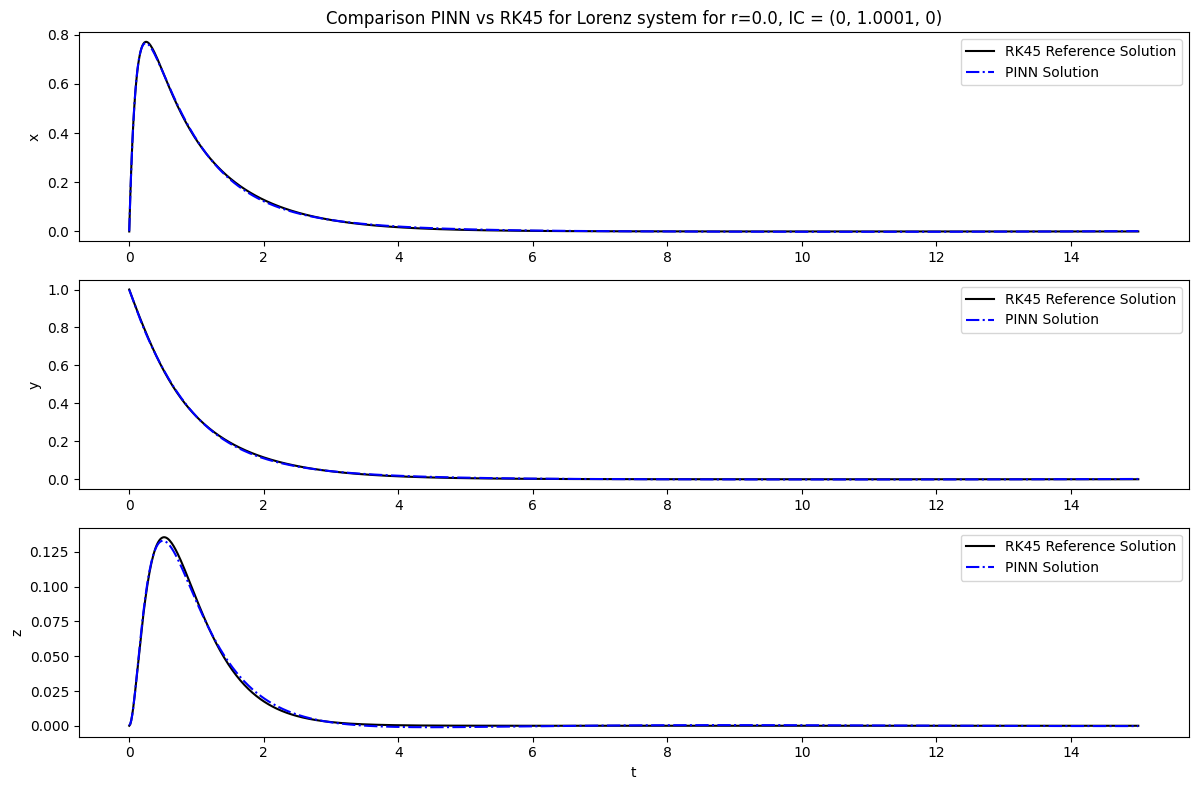

In [114]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0, 1.0001, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_sensitive_IC_r0,
    pinn_solution=y_pinn_sensitive_IC_r0,
    title=title
)

In [115]:
pinn.train(
    model_sensitive_IC_r1,
    t_initial=t_min,
    initial_conditions=sensitive_IC,
    A=A, B=B_1, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=4000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.166775181889534 | IC-Loss: 0.33340001106262207 | Physics-Loss: 0.00015036671538837254
Epoch 1000 Loss: 9.327815496362746e-05 | IC-Loss: 2.1960925096209394e-06 | Physics-Loss: 0.00018436022219248116
Epoch 2000 Loss: 9.615288581699133e-05 | IC-Loss: 8.71392387580272e-07 | Physics-Loss: 0.0001914343738462776
Epoch 3000 Loss: 0.00014801928773522377 | IC-Loss: 1.0026352583736298e-06 | Physics-Loss: 0.00029503594851121306
Training finished!


In [116]:
y_pinn_sensitive_IC_r1, phys_loss_sensitive_IC_r1 = pinn.pinn_predict(model_sensitive_IC_r1, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_1, C=C)
ic_mse_sensitive_IC_r1 = pinn_ic_mse(sol_rk45_sensitive_IC_r1, y_pinn_sensitive_IC_r1)
reference_mse_sensitive_IC_r1 = pinn_reference_mse(sol_rk45_sensitive_IC_r1, y_pinn_sensitive_IC_r1)

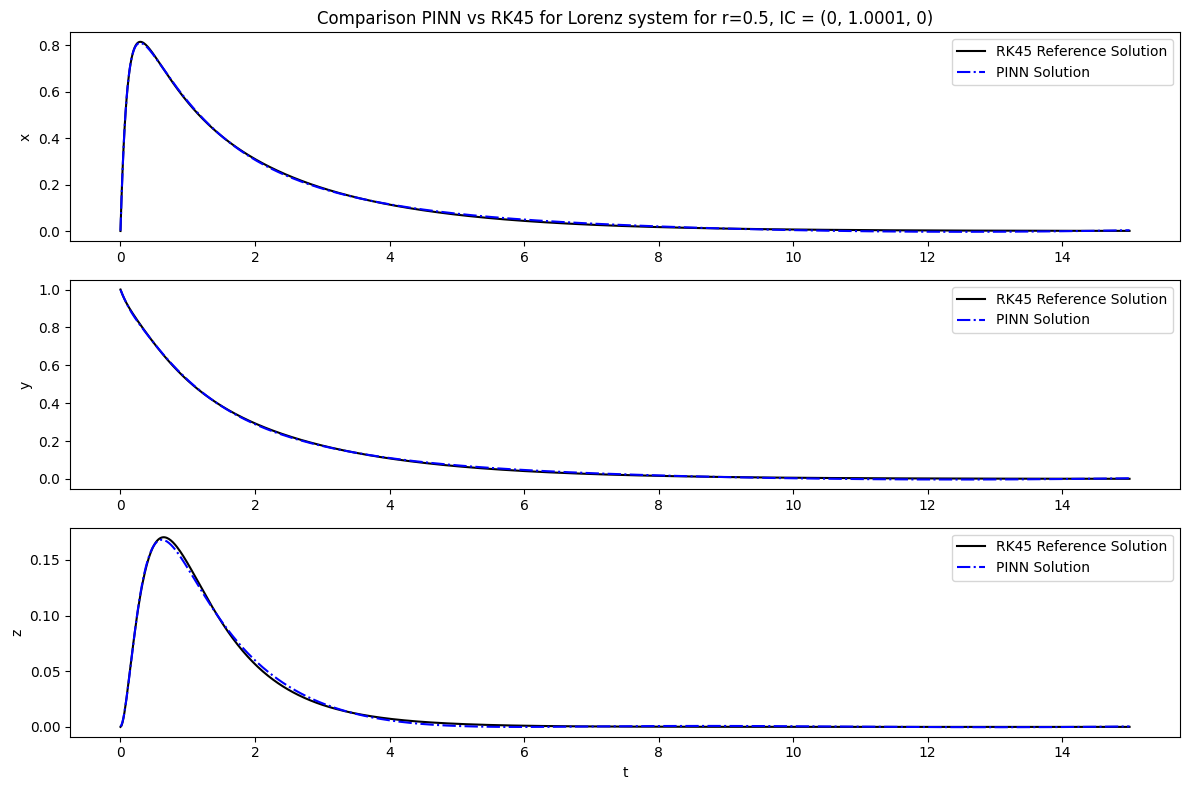

In [117]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_1}, IC = (0, 1.0001, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_sensitive_IC_r1,
    pinn_solution=y_pinn_sensitive_IC_r1,
    title=title
)

In [118]:
pinn.train(
    model_sensitive_IC_r2,
    t_initial=t_min,
    initial_conditions=sensitive_IC,
    A=A, B=B_2, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=4000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.16672448813915253 | IC-Loss: 0.33340001106262207 | Physics-Loss: 4.89770682179369e-05
Epoch 1000 Loss: 0.00021205187658779323 | IC-Loss: 4.768629423779203e-06 | Physics-Loss: 0.0004193351196590811
Epoch 2000 Loss: 0.00010272317740600556 | IC-Loss: 1.2990582263228134e-06 | Physics-Loss: 0.00020414729078765959
Epoch 3000 Loss: 7.289339555427432e-05 | IC-Loss: 3.0668326189697837e-07 | Physics-Loss: 0.0001454801094951108
Training finished!


In [119]:
y_pinn_sensitive_IC_r2, phys_loss_sensitive_IC_r2 = pinn.pinn_predict(model_sensitive_IC_r2, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_2, C=C)
ic_mse_sensitive_IC_r2 = pinn_ic_mse(sol_rk45_sensitive_IC_r2, y_pinn_sensitive_IC_r2)
reference_mse_sensitive_IC_r2 = pinn_reference_mse(sol_rk45_sensitive_IC_r2, y_pinn_sensitive_IC_r2)

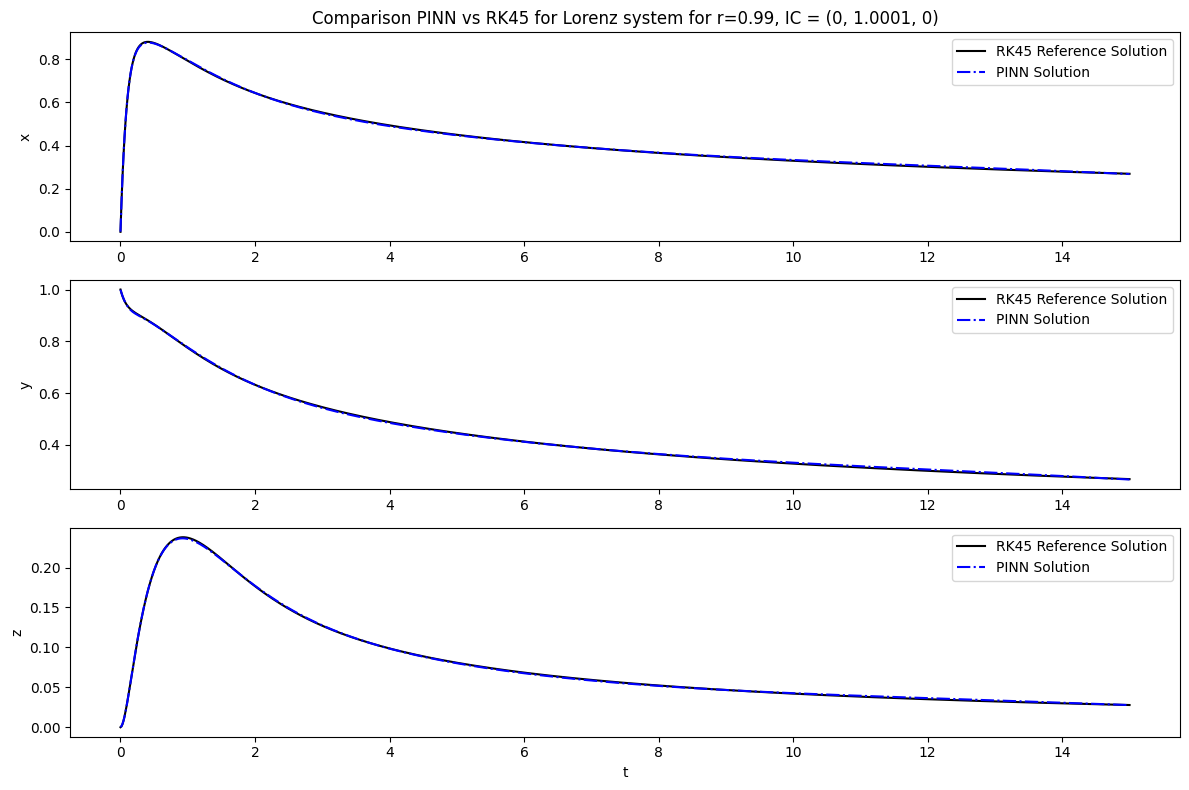

In [120]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_2}, IC = (0, 1.0001, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_sensitive_IC_r2,
    pinn_solution=y_pinn_sensitive_IC_r2,
    title=title
)

####  Anfangsbedingung (0.5, 0.5, 0.1)
Anfangsbedingung in der Nähe eines Fixpunktes der für r > 1 entsteht. 

In [121]:
c_plus_IC = np.array([0.5, 0.5, 0.1], dtype=np.float32)
t_eval, sol_rk45_c_plus_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, c_plus_IC)
t_eval, sol_rk45_c_plus_IC_r1 = hf.ref_solution(A, B_1, C, t_min, t_max, c_plus_IC)
t_eval, sol_rk45_c_plus_IC_r2 = hf.ref_solution(A, B_2, C, t_min, t_max, c_plus_IC)


model_c_plus_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_c_plus_IC_r1 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
model_c_plus_IC_r2 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [122]:
pinn.train(
    model_c_plus_IC_r0,
    t_initial=t_min,
    initial_conditions=c_plus_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.08510053157806396 | IC-Loss: 0.17000000178813934 | Physics-Loss: 0.00020106133888475597
Epoch 1000 Loss: 0.00027071958174929023 | IC-Loss: 0.0003683568211272359 | Physics-Loss: 0.0001730823132675141
Epoch 2000 Loss: 0.0002606345806270838 | IC-Loss: 0.0003676812630146742 | Physics-Loss: 0.00015358789823949337
Epoch 3000 Loss: 0.0002603133616503328 | IC-Loss: 0.00036633331910707057 | Physics-Loss: 0.00015429340419359505
Epoch 4000 Loss: 0.0002637428988236934 | IC-Loss: 0.00036681280471384525 | Physics-Loss: 0.00016067300748545676
Training finished!


In [123]:
y_pinn_c_plus_IC_r0, phys_loss_c_plus_IC_r0 = pinn.pinn_predict(model_c_plus_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_c_plus_IC_r0 = pinn_ic_mse(sol_rk45_c_plus_IC_r0, y_pinn_c_plus_IC_r0)
reference_mse_c_plus_r0 = pinn_reference_mse(sol_rk45_c_plus_IC_r0, y_pinn_c_plus_IC_r0)


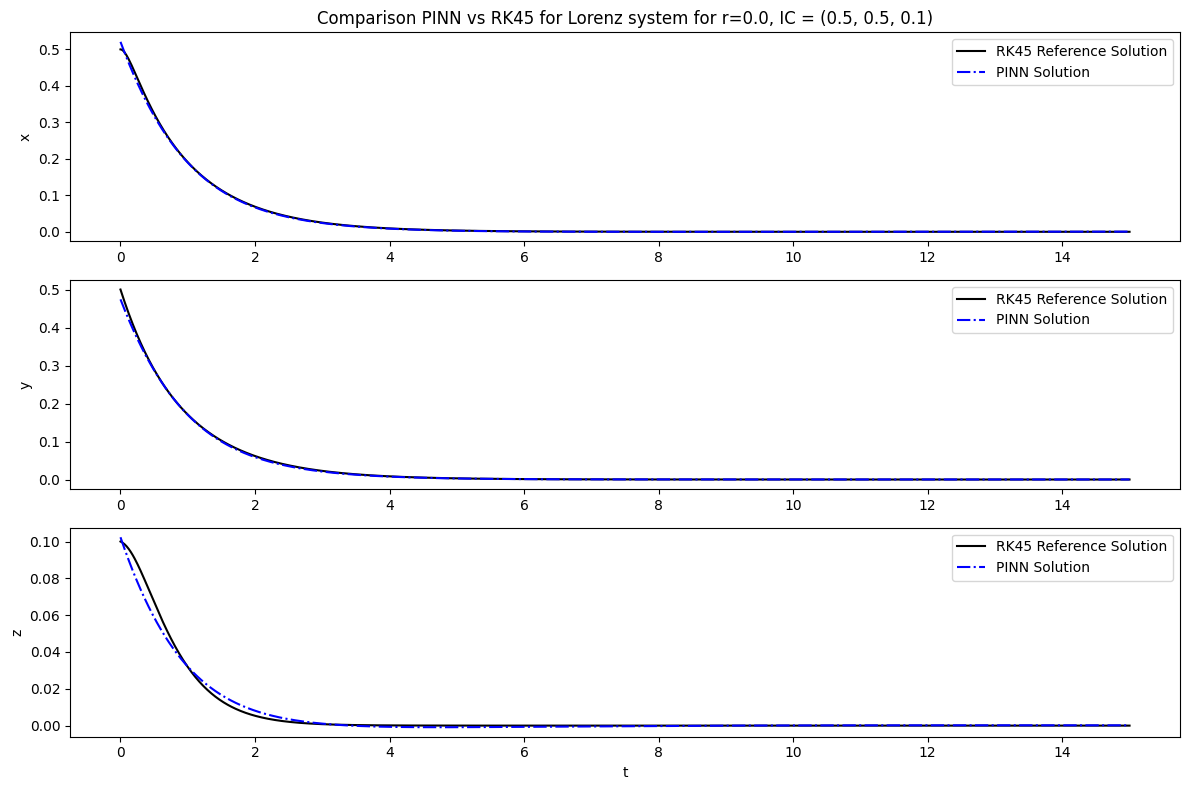

In [124]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0.5, 0.5, 0.1)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_c_plus_IC_r0,
    pinn_solution=y_pinn_c_plus_IC_r0,
    title=title
)

In [125]:
pinn.train(
    model_c_plus_IC_r1,
    t_initial=t_min,
    initial_conditions=c_plus_IC,
    A=A, B=B_1, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 0.08643122762441635 | IC-Loss: 0.17000000178813934 | Physics-Loss: 0.0028624474070966244
Epoch 1000 Loss: 7.863994687795639e-05 | IC-Loss: 0.00011273337440798059 | Physics-Loss: 4.454651934793219e-05
Epoch 2000 Loss: 7.869803812354803e-05 | IC-Loss: 0.00011097439710283652 | Physics-Loss: 4.642168278223835e-05
Epoch 3000 Loss: 7.961055234773085e-05 | IC-Loss: 0.0001103059621527791 | Physics-Loss: 4.8915146180661395e-05
Epoch 4000 Loss: 7.967313285917044e-05 | IC-Loss: 0.00011038020602427423 | Physics-Loss: 4.896605605608784e-05
Training finished!


In [126]:
y_pinn_c_plus_IC_r1, phys_loss_c_plus_IC_r1 = pinn.pinn_predict(model_c_plus_IC_r1, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_1, C=C)
ic_mse_c_plus_IC_r1= pinn_ic_mse(sol_rk45_c_plus_IC_r1, y_pinn_c_plus_IC_r1)
reference_mse_c_plus_r1 = pinn_reference_mse(sol_rk45_c_plus_IC_r1, y_pinn_c_plus_IC_r1)

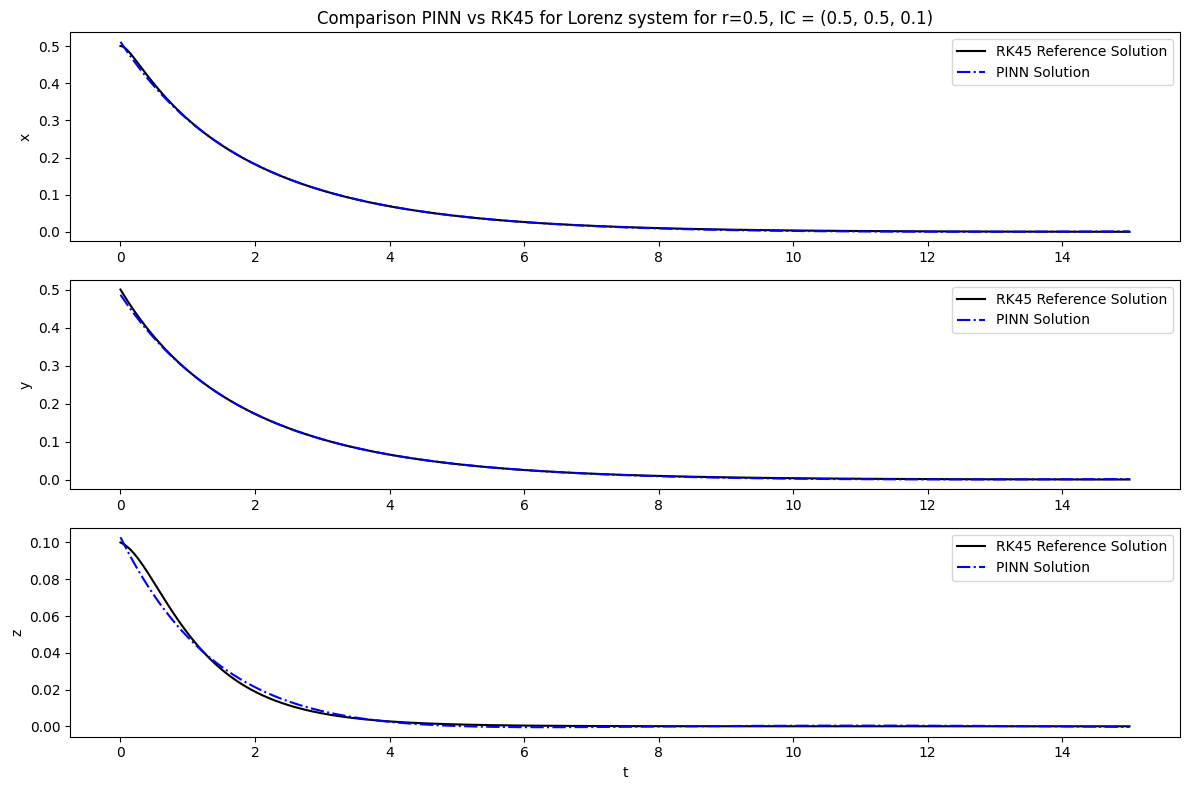

In [127]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_1}, IC = (0.5, 0.5, 0.1)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_c_plus_IC_r1,
    pinn_solution=y_pinn_c_plus_IC_r1,
    title=title
)

In [ ]:
pinn.train(
    model_c_plus_IC_r2,
    t_initial=t_min,
    initial_conditions=c_plus_IC,
    A=A, B=B_2, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS + 1000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )


Training started...
Epoch 0 Loss: 4.252045982866548e-05 | IC-Loss: 8.666033863846678e-06 | Physics-Loss: 7.637488306500018e-05
Training finished!


In [137]:
y_pinn_c_plus_IC_r2, phys_loss_c_plus_IC_r2 = pinn.pinn_predict(model_c_plus_IC_r2, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_2, C=C)
ic_mse_c_plus_IC_r2 = pinn_ic_mse(sol_rk45_c_plus_IC_r2, y_pinn_c_plus_IC_r2)
reference_mse_c_plus_r2 = pinn_reference_mse(sol_rk45_c_plus_IC_r2, y_pinn_c_plus_IC_r2)

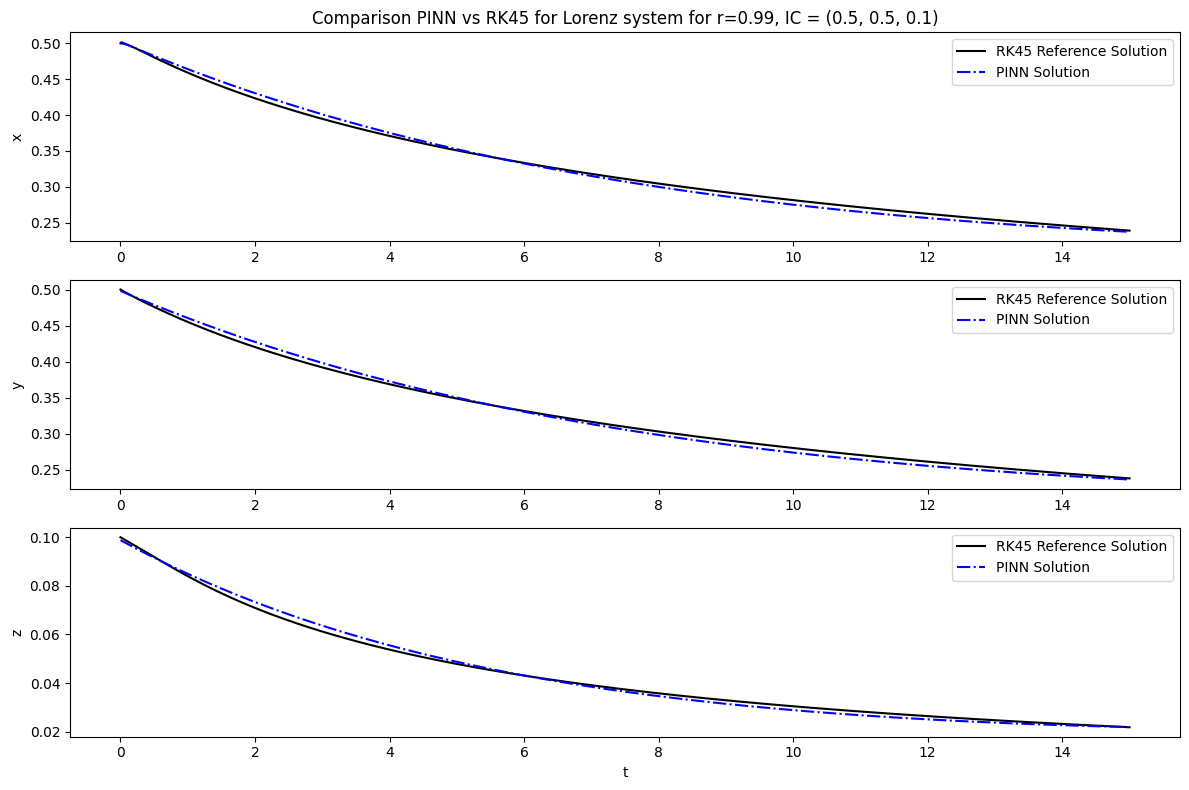

In [138]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_2}, IC = (0.5, 0.5, 0.1)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_c_plus_IC_r2,
    pinn_solution=y_pinn_c_plus_IC_r2,
    title=title
)